In [166]:
#%matplotlib notebook
from pprint import pprint
from utils import create_datasets, LineData
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from types import SimpleNamespace
plt.style.use('default')
from cycler import cycler
color_cycle = cycler(color=['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000'])
plt.rcParams['axes.prop_cycle'] = color_cycle
from datetime import datetime
import numpy as np 
import itertools

EYETRACKER_NAME = "EyeTracker:0"
EYETRACKERSTUB_NAME = "EyeTrackerStub"

TARGET_NAME = "Target:0"
WINDOW_SIZE = (800,800)
TRACKING_WINDOW_PROPERTIES = {'position': np.array((351.25, 37.85)), 'size': np.array((341.25, 341.25))}

img = mpimg.imread('./images/background.png') # background image

In [88]:
dataset = create_datasets(n=5)
# prune dataset to contain only those with valid eyetracking data...
#dataset = {k:data for k, data in dataset.items() if LineData.in_from_source(data, EYETRACKER_NAME)}
#dataset = list(sorted([(k,v) for k,v in dataset.items()], key=lambda x: x[0][:3]))
#dataset = {k:list(g) for k,g in itertools.groupby(dataset, key=lambda x: x[0][:3])}

print(dataset.keys())


loading files...: 5it [00:01,  2.87it/s]

dict_keys(['000test.txt', 'P00icuA.txt', 'P00icuB.txt', 'P00icuaA.txt', 'P00icuaB.txt'])


start: 2021-08-23 15:31:22.201557, finish: 2021-08-23 15:34:22.201548, duration: 180s
WarningLight:0      , failure proportion: 0.06, total failures: 3
WarningLight:1      , failure proportion: 0.08, total failures: 4
Scale:0             , failure proportion: 0.01, total failures: 2
Scale:1             , failure proportion: 0.01, total failures: 2
Scale:2             , failure proportion: 0.04, total failures: 2
Scale:3             , failure proportion: 0.01, total failures: 1
start: 2021-08-23 15:35:12.944969, finish: 2021-08-23 15:38:12.944656, duration: 180s
WarningLight:0      , failure proportion: 0.10, total failures: 8
WarningLight:1      , failure proportion: 0.07, total failures: 7
Scale:0             , failure proportion: 0.09, total failures: 7
Scale:1             , failure proportion: 0.07, total failures: 8
Scale:2             , failure proportion: 0.13, total failures: 7
Scale:3             , failure proportion: 0.11, total failures: 7
start: 2021-08-23 15:42:27.812798, f

'\nfor (par, group) in dataset.items():\n    for (k, data) in group:\n        data = data_system_task(data)\n        break\n    break\n\n'

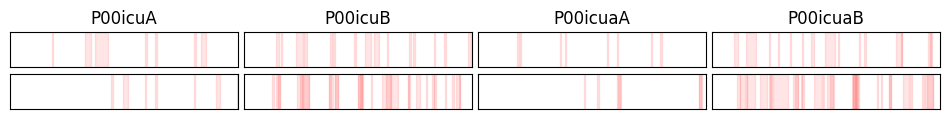

In [187]:
# computes the failure statistics for the system monitoring task


def create_subplots(nrows=2, ncols=4):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,1),
                            gridspec_kw={'width_ratios':[1,1,1,1], 'height_ratios':[1,1], 
                                         'wspace':1/40, 'hspace':0.2})
    for ax in axs.ravel():
        ax.set_xticklabels([])
        ax.set_yticklabels([]) 
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    return fig, axs



fig, axs = create_subplots(nrows=2, ncols=4)
_dataset = {**dataset}
del _dataset['000test.txt']

for (k, linedata), ax in zip(_dataset.items(), axs.T):
    data = data_system_task(linedata)
    print(f"start: {datetime.fromtimestamp(data['start_time'])}, finish: {datetime.fromtimestamp(data['finish_time'])}, duration: {data['finish_time']-data['start_time']:2.0f}s")
    
    ax[0].set_title(k.split(".")[0])
    for (k,x), _ax in zip(data['components'].items(), [ax[0], ax[0], ax[1], ax[1], ax[1], ax[1]]): 
        result = compute_time_in_failure(x[:,2], x[:,0], data['start_time'], data['finish_time'])
        for interval in result['failure_intervals']:
            _ax.axvspan(*interval, alpha=0.1, color='red')
        _ax.set_xlim(data['start_time'], data['finish_time'])
        
        # compute per component statistics
     
        print(f"{k:20}, failure proportion: {result['failure_proportion']:.2f}, total failures: {result['failures'].sum()}")
    
    
   
        
    
# compute 

    
        
    


    
"""
for (par, group) in dataset.items():
    for (k, data) in group:
        data = data_system_task(data)
        break
    break

"""    
    

In [ ]:
# plot target data
def data_tracking_task(data, l2_threshold):
    def failure_l2(x, y, l2_threshold=50): 
        return np.sqrt(x ** 2 + y ** 2) > l2_threshold
    target_data = LineData.findall_from_source(data, TARGET_NAME)
    target_data = LineData.pack_variables(target_data, "timestamp", "x", "y")
    target_data = np.array(target_data)
    fail = failure_l2(target_data[:,1], target_data[:,2], l2_threshold=l2_threshold)    
    return np.concatenate([target_data, fail[:,np.newaxis]], axis=-1)
    
def plot_tracking_task(target_data, ax, ax_prop, l2_threshold, tracking_window_properties, title):
    
    alpha = 0.5
    tracking_window_center = tracking_window_properties['position'] + tracking_window_properties['size']/2
    target_data[:,-3:-1] +=  tracking_window_center # absolute (window) coordinates 
    t,x,y,fail = target_data.T
    
    ax.imshow(img)
    #ax.plot(*(target_data[:,-2:]).T, color="black", alpha=0.1)
    ax.scatter(x,y, marker=".", c=np.array(['blue', 'red'])[fail.astype(int)], alpha=alpha)
    tracking_window_lims = np.stack([tracking_window_properties['position'], tracking_window_properties['position'] + TRACKING_WINDOW_PROPERTIES['size']])
    ax.set_xlim(tracking_window_lims[:,0])
    ax.set_ylim(tracking_window_lims[:,1])
    ax.invert_yaxis()
    ax.set_xticklabels([])
    ax.set_yticklabels([]) 
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_title(title.split(".")[0])
    # valid target locations
    circ = plt.Circle(tracking_window_center, l2_threshold, fill=False, color="blue")
    ax.add_patch(circ)

    ax_prop.set_xlim(0,1)
    ax_prop.set_ylim(0,1)
    ax_prop.set_xticklabels([])
    ax_prop.set_yticklabels([]) 
    ax_prop.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    # fill proportion out of bounds

    prop_fail = fail.sum() / fail.shape[0]
    ax_prop.text(0.02, 0.25, f"{1-prop_fail:.2f}", fontsize=12, color="black")
    ax_prop.text(1-0.25, 0.25, f"{prop_fail:.2f}", fontsize=12, color="black")

    ax_prop.axvspan(0, 1-prop_fail, alpha=alpha, color='blue')
    ax_prop.axvspan(1-prop_fail, 1, alpha=alpha, color='red')
    
def create_subplots(dataset, nrows=1, ncols=4):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,3),
                            gridspec_kw={'width_ratios':[1,1,1,1], 'height_ratios':[10,1], 
                                         'wspace':0.05, 'hspace':-0.3})
    return fig, axs

L2_THRESHOLD = 50 # default for the icua agents

for (par, group) in dataset.items():
    fig, axs = create_subplots(dataset, nrows=2)
    for (k, data), ax in zip(group, axs.T):
        data = data_tracking_task(data, L2_THRESHOLD)
        plot_tracking_task(data, ax[0], ax[1], L2_THRESHOLD, TRACKING_WINDOW_PROPERTIES, k)
        
        # do some other analysis of this data? save it somewhere?
        
        
        
    #plt.savefig(f"./images/tracking/{par}.png", bbox_inches="tight")
    plt.show()
    break
    
    
    
    

In [ ]:

for k, data in itertools.islice(dataset.items(), None):    
    eye_data = LineData.findall_from_source(data, EYETRACKER_NAME)
    eye_data = LineData.pack_variables(eye_data, "timestamp", "label", "x", "y", )
    eye_data = np.array(eye_data)
    sac = eye_data[:,1] == "saccade"
    t, x, y = eye_data[:,0].astype(np.float32), eye_data[:,2].astype(np.float32), eye_data[:,3].astype(np.float32)
    
    fig = plt.figure()
    fig.suptitle(k.split(".")[0])
    plt.imshow(img)
    plt.scatter(x,y, alpha=0.1, marker=".", c=np.array(['black', 'white'])[sac.astype(int)])
    #rect = plt.Rectangle((0,0), *WINDOW_SIZE, fill=False)
    #plt.gca().add_patch(rect)
    plt.gca().set_xlim(0,WINDOW_SIZE[0])
    plt.gca().set_ylim(0,WINDOW_SIZE[1])
    plt.gca().set_aspect("equal")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("./data/images/" + k.split(".")[0] + ".png", bbox_inches="tight")
    plt.close()


In [ ]:
plt.imshow("./data/background.png")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image using imread()
img = mpimg.imread('./data/background.png')

plt.figure()
# Display the image using imshow()
plt.imshow(img)
plt.show()


In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create the plot
fig, ax = plt.subplots()

# Plot the data
ax.plot(x, y)

# Set limits and ticks for the y-axis
ax.set_ylim(-1.2, 1.2)
ax.set_yticks(np.arange(-1, 1.1, 0.5))

# Draw the filled box outside the y-axis
box_coordinates = np.array([[-2, -10], [-2, 1.2], [0, 1.2], [0, -1.2]])
ax.fill_betweenx(box_coordinates[:, 1], box_coordinates[:, 0], color='lightgray')
print(box_coordinates[:,1])
# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create the plot
fig, ax = plt.subplots()

# Plot the data
ax.plot(x, y)

# Draw the filled box outside the plot axis below the x-axis
box_coordinates = np.array([[x.min(), ax.get_ylim()[0]], [x.min(), ax.get_ylim()[0]-0.2],
                            [x.max(), ax.get_ylim()[0]-0.2], [x.max(), ax.get_ylim()[0]]])
ax.fill_between(box_coordinates[:, 0], box_coordinates[:, 1], color='lightgray', zorder=-1)

# Display the plot
plt.show()


In [34]:
x = np.array([0,0,0,1,1,1,1,0,0,1,0,1,0,1,1,1,1,0])
y = np.pad(np.logical_xor(x[:-1], x[1:]), (1,0)).astype(int)

yi = np.arange(y.shape[0])[y.astype(bool)]

print(x)
print(y)
print(yi)
print(yi.reshape(yi.shape[0]//2,2))



[0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0]
[0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1]
[ 3  7  9 10 11 12 13 17]
[[ 3  7]
 [ 9 10]
 [11 12]
 [13 17]]


(7,)
[[0.5 1. ]]
[0.5] 0.5


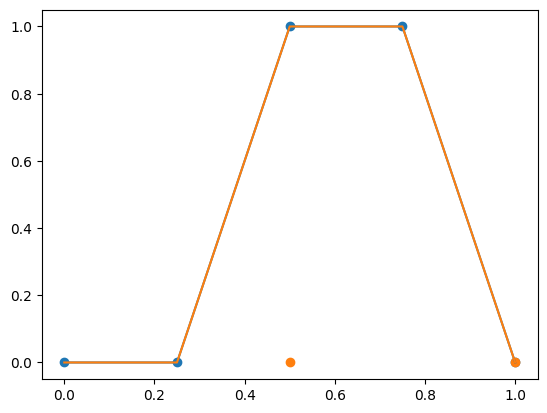

In [73]:
def compute_time_in_failure(fail, timestamps, starttime, finishtime):
    fail = np.pad(fail.astype(np.uint8), (1,1)) # pad with zeros either side (ensures even index cardinality)
    timestamps = np.pad(timestamps, (1,1))      # pad with start/end time
    timestamps[0] = starttime
    timestamps[-1] = finishtime
    y = np.pad(np.logical_xor(fail[:-1], fail[1:]), (1,0))
    yi = np.arange(y.shape[0])[y]
    ts = timestamps[yi].reshape(-1,2)
    df = ts[:,1] - ts[:,0]
    return ts, df.sum() / (finishtime - starttime) # failure intervals, proportion of failure
    
   
    
    
    
x = np.array([0,0,1,1,0])
z = np.linspace(0,1,x.shape[0])

plt.figure()
plt.plot(z,x)
plt.scatter(z,x)

compute_time_in_failure(x, z, 0.0, 1)
